<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-first-run" data-toc-modified-id="Simple-first-run-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple first run</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simple first run

1. Iniatilize NxN grid
2. Compute the initial energy $E$
3. Flip random spin and compute $\Delta E$
4. Accept or reject based on criteria
5. Continue to 3

In [143]:
# Insight from using full energy
np.seterr(over='raise')

{'divide': 'warn', 'over': 'raise', 'under': 'ignore', 'invalid': 'warn'}

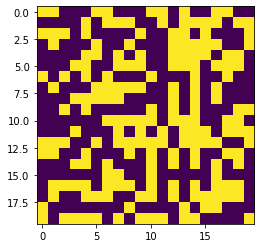

In [157]:
N = 20
grid = np.random.randint(low=0, high=2, size=(N, N))
plt.imshow(grid)
# Rescale to +-1
grid = -1 + 2*grid

In [158]:
beta = 1/10

# This is not efficient, but is clear to read
E = 0
e_0 = 50
for i in range(N):
    for j in range(N):
        E += e_0*int(grid[i,j] * grid[(i+1)%N, j])
        E += e_0*int(grid[i,j] * grid[i-1, j])
        E += e_0*int(grid[i,j] * grid[i, (j+1)%N])
        E += e_0*int(grid[i,j] * grid[i, j-1])

        
averages = []
energies = []
print('Starting energy', E)
for n in range(int(1e3)):
    averages.append(np.mean(grid))
    energies.append(E)
    i, j = (np.random.randint(0, N, size=(2,)))
    x = grid[i, j]
    grid[i, j] = - x
    dE = 0
    dE += x * grid[(i+1)%20, j]
    dE += x * grid[i-1, j]
    dE += x * grid[i, (j+1)%20]
    dE += x * grid[i, j-1]
    dE += x
    dE *= -2*e_0
    
    accept_p = min(1, np.exp(-beta*dE))
    
    if accept_p>np.random.rand():
        E = E + dE
    else:
        #reset it back
        grid[i, j] = x
    

Starting energy 1600


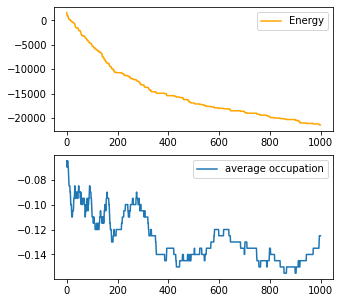

In [159]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
plt.plot(averages, label='average occupation') 
plt.legend()
plt.sca(axs[0])
plt.plot(energies, label='Energy', color='orange') 
plt.legend()

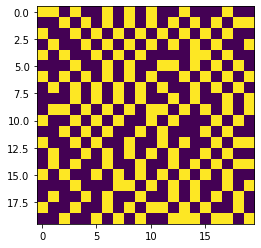

In [160]:
plt.imshow(grid)